In [18]:
from pyquil import get_qc, Program
from pyquil.api import BenchmarkConnection
from pyquil.gates import CZ, I, H, S, MEASURE, X, CNOT, FENCE, RZ
from pyquil.paulis import PauliTerm, ID
from pyquil.latex import display
from pyquil.quil import Pragma
import networkx as nx
from itertools import cycle, product, permutations
from random import choice
from scipy.optimize import curve_fit, nnls
import scipy as sc
import numpy as np
from itertools import combinations
from matplotlib import pyplot as plt
from numpy import pi
from collections import Counter

# Circuit generation

In [19]:
qpu = get_qc("9q-qvm", noisy=True)
layer = Program(CZ(0,1))

In [20]:
DOUBLE_GATE = 2
SINGLE_GATE = 1
NUM_BASES = 9

qubits = layer.get_qubits()
layer = Program([inst for inst in layer if len(inst.get_qubits()) == 2])
n = len(qubits)
topology = qpu.qubit_topology().subgraph(qubits)

def instance(
    prep_basis, 
    meas_basis, 
    noise_repetitions : int, 
    transpiled=True
    ):

    bc = BenchmarkConnection()

    circ = Program(Pragma('INITIAL_REWIRING', ['"NAIVE"']))
    ro = circ.declare("ro", "BIT", n)

    #get preparation ops from desired basis 
    def prep(basis, qubit):
        if basis == "X":
            return H(qubit)
        elif basis == "Y":
            return Program(H(qubit),S(qubit))
        return I(qubit)

    def meas(basis, qubit):
        if basis == "X":
            return H(qubit)
        elif basis == "Y":
            return Program(RZ(-pi/2, qubit), H(qubit))
        return I(qubit)
    
    pauli_frame = ID()

    #apply the prep and twirling operators to the circuit
    qc = Program()
    qc += [prep(b,qubit) for qubit,b in prep_basis]

    #apply repetitions of noise, including basis-change gates when needed
    for i in range(noise_repetitions):
        twirl = PauliTerm.from_list([(choice("IXYZ"),q) for q in qubits]) 
        qc += twirl.program

        if transpiled:
            circ += qpu.compiler.quil_to_native_quil(qc)
        else:
            circ += qc

        circ += layer
        qc = Program()
        pauli_frame *= twirl
        pauli_frame = bc.apply_clifford_to_pauli(layer, pauli_frame)

    rostring = PauliTerm.from_list([(choice("IX"),q) for q in qubits]) 
    qc += pauli_frame.program
    qc += [meas(b,q) for q,b in meas_basis]
    qc += rostring.program

    if transpiled:
        circ += qpu.compiler.quil_to_native_quil(qc)
    else:
        circ += qc
    
    circ += [MEASURE(q,ro[i]) for i,q in enumerate(qubits)]

    return circ, {
        "prep_basis":prep_basis,
            "meas_basis":meas_basis, 
            "depth":noise_repetitions, 
            "rostring": tuple({"I":0,"X":1}[char] for char in  rostring.pauli_string(qubits))
        }

## The issue
This example below produces the desired results with `quil_to_native_quil` turned off.

In [21]:
circ, data = instance(PauliTerm.from_list([("X",0),("Y",1)]),PauliTerm.from_list([("X",0),("Y",1)]),2, transpiled=False)
exe = qpu.compiler.native_quil_to_executable(circ)
ro = qpu.run(exe).readout_data['ro']
print(ro)

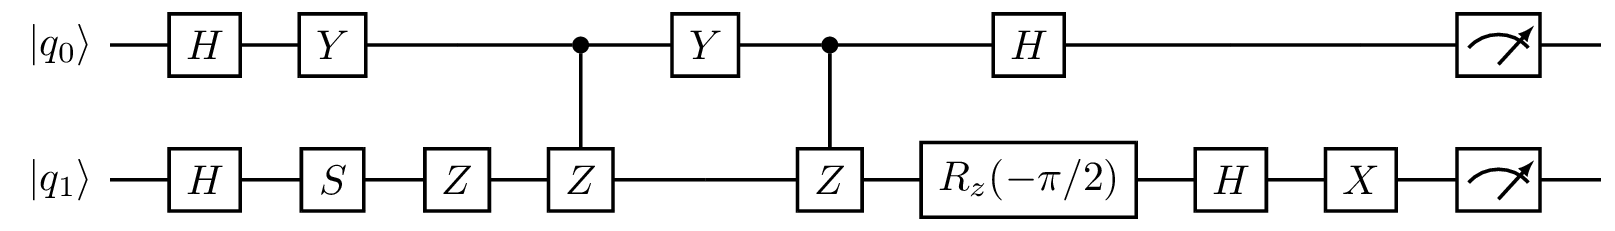

In [23]:
display(exe)

Once `quil_to_native_quil` is turned on, the readout is no longer recorded correctly. The circuit seems to display with the correct readout instructions, do you know what could be going on here?

In [43]:
circ, data = instance(PauliTerm.from_list([("X",0),("Y",1)]),PauliTerm.from_list([("X",0),("Y",1)]),2, transpiled=True)
exe = qpu.compiler.native_quil_to_executable(circ)
ro = qpu.run(exe).readout_data['ro']
print(ro)

[[0 0]]


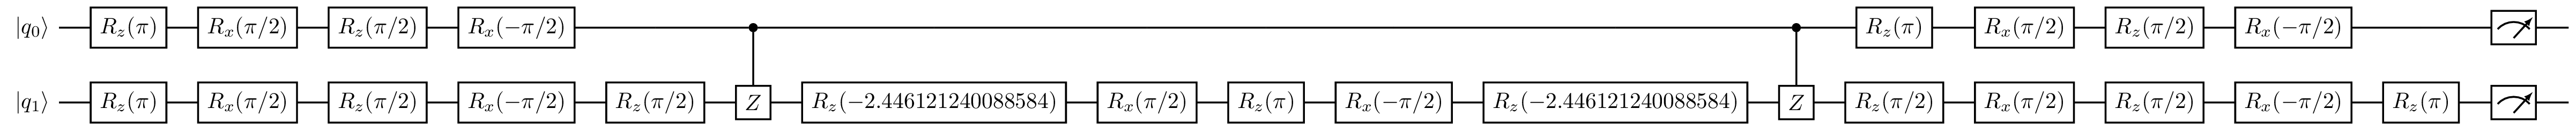

In [41]:
display(exe)